# 필요 라이브러리

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# 데이터 가져오기

In [35]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

DATA_PATH = '/opt/ml/input/data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 3.9 s, sys: 284 ms, total: 4.18 s
Wall time: 4.18 s


In [36]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


## 문제들을 푸는데 걸린 시간

In [37]:
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff

In [38]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24.0
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,6632178.0
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11.0
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46.0


## 시험지별 정답률

In [39]:
def percentile(s):
    return np.sum(s) / len(s)

test_groupby = df.groupby('testId').agg({
    'userID': 'count',
    'answerCode': percentile
})
test_groupby.describe()

,userID,answerCode
count,1537.000000,1537.000000
mean,1474.681848,0.667982
std,533.526783,0.138903
min,172.000000,0.327186
25%,1320.000000,0.561819
50%,1400.000000,0.680519
75%,1602.000000,0.778439
max,3960.000000,0.955474


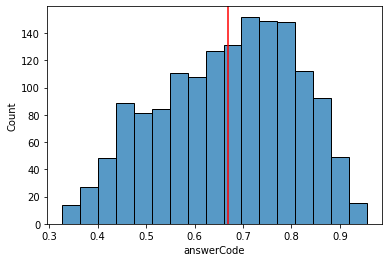

In [40]:
fig, ax = plt.subplots()
g = sns.histplot(test_groupby['answerCode'])
g.axvline(test_groupby['answerCode'].mean(), color='red')

## 태그 별 정답률

In [41]:
tag_groupby = df.groupby('KnowledgeTag').agg({
    'userID': 'count',
    'answerCode': percentile
})
tag_groupby.describe()

,userID,answerCode
count,912.000000,912.000000
mean,2485.291667,0.615524
std,1732.086925,0.148329
min,44.000000,0.188940
25%,1025.250000,0.498239
50%,2204.000000,0.599585
75%,4052.750000,0.740288
max,12892.000000,0.977778


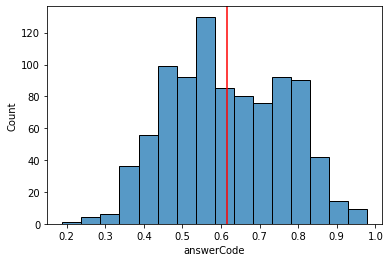

In [42]:
fig, ax = plt.subplots()
g = sns.histplot(tag_groupby['answerCode'])
g.axvline(tag_groupby['answerCode'].mean(), color='red')

## 태그 전체 데이터 수

In [43]:
df['KnowledgeTag'].value_counts()[:15]

7597     12892
7600     10734
2010     10176
7621      9709
8127      9006
8004      8394
2085      8247
10169     8180
2065      7945
7599      7231
4210      7229
1260      7106
5788      6830
8420      6354
7596      6250
Name: KnowledgeTag, dtype: int64

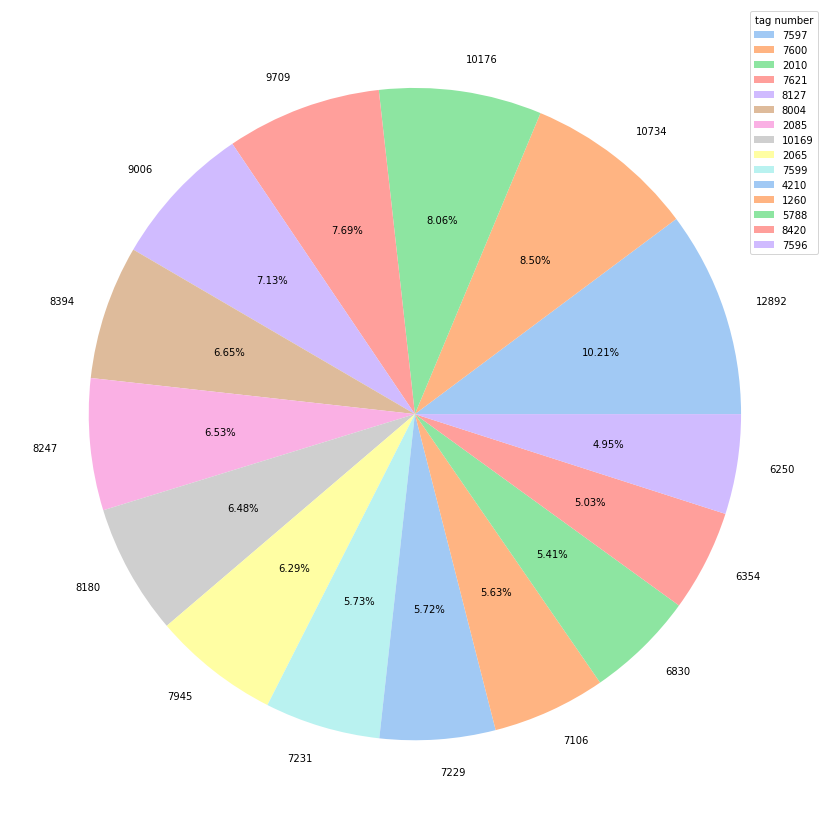

In [44]:
plt.figure(figsize=(15,15))
labels, data = zip(*df['KnowledgeTag'].value_counts()[:15].items())
plt.pie(data, labels = data, colors = sns.color_palette('pastel'), autopct='%.2f%%')
plt.legend(labels, title='tag number')
plt.show()


## 문제가 뒤로 갈수록 난이도가 높은가?

In [45]:
df['userID'].value_counts(ascending = False)

730     1860
481     1847
1112    1777
394     1774
926     1773
        ... 
7396      14
7414      13
7390      13
7252      13
7441       9
Name: userID, Length: 6698, dtype: int64

In [46]:
# 가장 푼 문제가 많은 학생
most_passion_student_df = df.loc[(df.userID == 730)]
most_passion_student_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
520750,730,A040007001,A040000007,1,2020-02-04 08:32:53,7271,0.0
520751,730,A040007002,A040000007,1,2020-02-04 08:33:07,7271,14.0
520752,730,A040007003,A040000007,1,2020-02-04 08:33:20,7271,13.0
520753,730,A040007004,A040000007,1,2020-02-04 08:34:00,7271,40.0
520754,730,A040007005,A040000007,1,2020-02-04 08:34:14,7271,14.0
...,...,...,...,...,...,...,...
522605,730,A070158003,A070000158,0,2020-12-28 06:54:55,9797,2.0
522606,730,A070158004,A070000158,0,2020-12-28 06:54:58,9797,3.0
522607,730,A070158006,A070000158,0,2020-12-28 06:55:00,9797,2.0
522608,730,A070158008,A070000158,0,2020-12-28 06:55:02,9797,2.0


In [47]:
# 가장 푼 문제가 많은 학생의 가장 많이 푼 시험지
most_passion_student_df['testId'].value_counts()

A070000052    12
A070000051    12
A070000058    12
A070000017    12
A070000043    12
              ..
A050000191     4
A050000189     4
A050000193     4
A040000022     3
A040000028     3
Name: testId, Length: 259, dtype: int64

In [48]:
most_passion_student_most_paper_df = df.loc[(df.userID == 730) & (df.testId == "A070000052")]
most_passion_student_most_paper_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
521619,730,A070052001,A070000052,1,2020-08-01 02:59:22,1261,3522.0
521620,730,A070052002,A070000052,1,2020-08-01 02:59:44,1261,22.0
521621,730,A070052003,A070000052,0,2020-08-01 03:01:02,9166,78.0
521622,730,A070052004,A070000052,1,2020-08-01 03:01:24,6796,22.0
521623,730,A070052005,A070000052,0,2020-08-01 03:01:41,6784,17.0
521624,730,A070052006,A070000052,1,2020-08-01 03:01:59,6796,18.0
521625,730,A070052007,A070000052,1,2020-08-01 03:06:29,6785,270.0
521626,730,A070052009,A070000052,1,2020-08-01 03:07:05,6785,36.0
521627,730,A070052008,A070000052,1,2020-08-01 03:07:06,1260,1.0
521628,730,A070052010,A070000052,1,2020-08-01 03:07:33,6785,27.0


In [49]:
xticks_list = most_passion_student_most_paper_df['assessmentItemID'].unique()
processed_xtics_list = list(map(lambda x : x[-3:],xticks_list))

answerCode_list = list(most_passion_student_most_paper_df['answerCode'])
answerCode_list

col = []
for c in answerCode_list[1:]:
    if c == 1:
        col.append('royalblue')
    else:
        col.append('tomato')

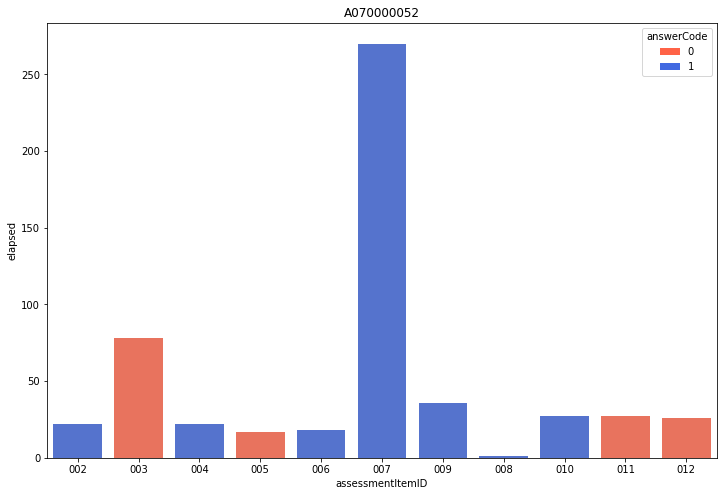

In [50]:
plt.figure(figsize=(12,8))
g = sns.barplot(x=most_passion_student_most_paper_df['assessmentItemID'][1:], y=most_passion_student_most_paper_df['elapsed'], palette=col)
g.set_xticklabels(processed_xtics_list[1:])
g.legend([Patch(facecolor='tomato'), Patch(facecolor='royalblue')], [0,1], title='answerCode')
plt.title('A070000052')
plt.show()

In [51]:
second_passion_student_df = df.loc[(df.userID == 481)]
second_passion_student_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
354395,481,A070003001,A070000003,0,2020-03-01 02:47:37,3793,0.0
354396,481,A070003002,A070000003,0,2020-03-01 02:47:43,3793,6.0
354397,481,A070003003,A070000003,0,2020-03-01 02:47:46,3793,3.0
354398,481,A070003004,A070000003,1,2020-03-01 02:47:50,117,4.0
354399,481,A070003005,A070000003,0,2020-03-01 02:47:53,3792,3.0
...,...,...,...,...,...,...,...
356237,481,A070130004,A070000130,1,2020-12-29 02:08:36,9069,2.0
356238,481,A070130005,A070000130,0,2020-12-29 02:08:40,9067,4.0
356239,481,A070130006,A070000130,0,2020-12-29 02:08:43,9069,3.0
356240,481,A070130007,A070000130,1,2020-12-29 02:08:45,9070,2.0


In [52]:
most_passion_student_df = df.loc[(df.userID == 1112)]
most_passion_student_df['testId'].value_counts()

A030000039    11
A030000033    10
A080000073     8
A080000007     8
A080000068     8
              ..
A060000027     4
A060000026     4
A030000027     4
A060000080     3
A060000064     3
Name: testId, Length: 281, dtype: int64

In [53]:
most_passion_student_df[most_passion_student_df.testId == 'A030000033']

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
766034,1112,A030033001,A030000033,0,2020-03-17 11:24:34,342,84788.0
766035,1112,A030033002,A030000033,0,2020-03-17 11:24:51,342,17.0
766036,1112,A030033003,A030000033,1,2020-03-17 11:24:59,342,8.0
766037,1112,A030033004,A030000033,1,2020-03-17 11:25:20,342,21.0
766038,1112,A030033005,A030000033,1,2020-03-17 11:25:55,342,35.0
766039,1112,A030033006,A030000033,0,2020-03-17 11:26:31,346,36.0
766040,1112,A030033007,A030000033,1,2020-03-17 11:26:42,346,11.0
766041,1112,A030033008,A030000033,1,2020-03-17 11:26:54,346,12.0
766042,1112,A030033009,A030000033,1,2020-03-17 11:27:15,342,21.0
766043,1112,A030033010,A030000033,1,2020-03-17 11:27:37,346,22.0


In [54]:
second_passion_student_most_paper_df = df.loc[(df.userID == 1112) & (df.testId == "A030000033")]
second_passion_student_most_paper_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
766034,1112,A030033001,A030000033,0,2020-03-17 11:24:34,342,84788.0
766035,1112,A030033002,A030000033,0,2020-03-17 11:24:51,342,17.0
766036,1112,A030033003,A030000033,1,2020-03-17 11:24:59,342,8.0
766037,1112,A030033004,A030000033,1,2020-03-17 11:25:20,342,21.0
766038,1112,A030033005,A030000033,1,2020-03-17 11:25:55,342,35.0
766039,1112,A030033006,A030000033,0,2020-03-17 11:26:31,346,36.0
766040,1112,A030033007,A030000033,1,2020-03-17 11:26:42,346,11.0
766041,1112,A030033008,A030000033,1,2020-03-17 11:26:54,346,12.0
766042,1112,A030033009,A030000033,1,2020-03-17 11:27:15,342,21.0
766043,1112,A030033010,A030000033,1,2020-03-17 11:27:37,346,22.0


In [55]:
xticks_list = second_passion_student_most_paper_df['assessmentItemID'].unique()
processed_xtics_list = list(map(lambda x : x[-3:],xticks_list))

answerCode_list = list(second_passion_student_most_paper_df['answerCode'])
answerCode_list

col = []
for c in answerCode_list[1:]:
    if c == 1:
        col.append('dodgerblue')
    else:
        col.append('indianred')

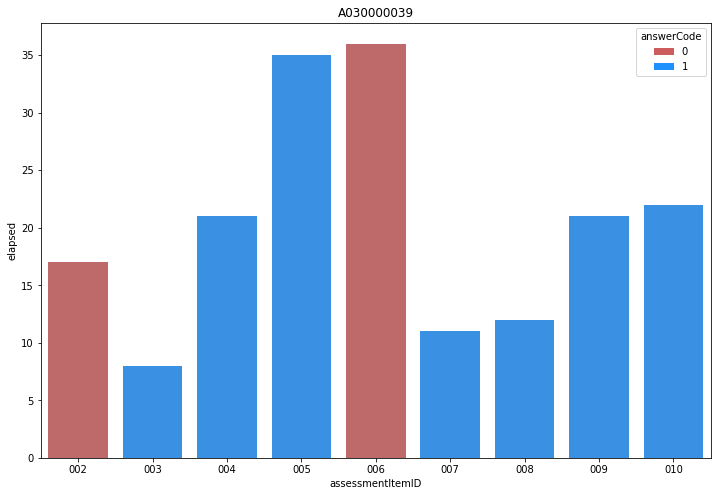

In [56]:
plt.figure(figsize=(12,8))
g = sns.barplot(x=second_passion_student_most_paper_df['assessmentItemID'][1:], y=second_passion_student_most_paper_df['elapsed'], palette=col)
g.set_xticklabels(processed_xtics_list[1:])
g.legend([Patch(facecolor='indianred'), Patch(facecolor='dodgerblue')], [0,1], title='answerCode')
plt.title('A030000039')
plt.show()

In [57]:
third_passion_student_most_paper_df = df.loc[(df.userID == 481) & (df.testId == "A070000017")]
third_passion_student_most_paper_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
354466,481,A070017001,A070000017,0,2020-04-08 07:59:00,7665,80137.0
354467,481,A070017002,A070000017,0,2020-04-08 07:59:02,7665,2.0
354468,481,A070017003,A070000017,0,2020-04-08 07:59:05,7665,3.0
354469,481,A070017005,A070000017,0,2020-04-08 07:59:09,7667,4.0
354470,481,A070017006,A070000017,0,2020-04-08 07:59:12,121,3.0
354471,481,A070017007,A070000017,0,2020-04-08 07:59:14,5619,2.0
354472,481,A070017008,A070000017,1,2020-04-08 07:59:16,7667,2.0
354473,481,A070017009,A070000017,0,2020-04-08 07:59:18,121,2.0
354474,481,A070017011,A070000017,0,2020-04-08 07:59:22,7665,4.0
354475,481,A070017012,A070000017,0,2020-04-08 07:59:25,121,3.0


In [58]:
xticks_list = third_passion_student_most_paper_df['assessmentItemID'].unique()
processed_xtics_list = list(map(lambda x : x[-3:],xticks_list))

answerCode_list = list(third_passion_student_most_paper_df['answerCode'])
answerCode_list

col = []
for c in answerCode_list[1:]:
    if c == 1:
        col.append('dodgerblue')
    else:
        col.append('indianred')

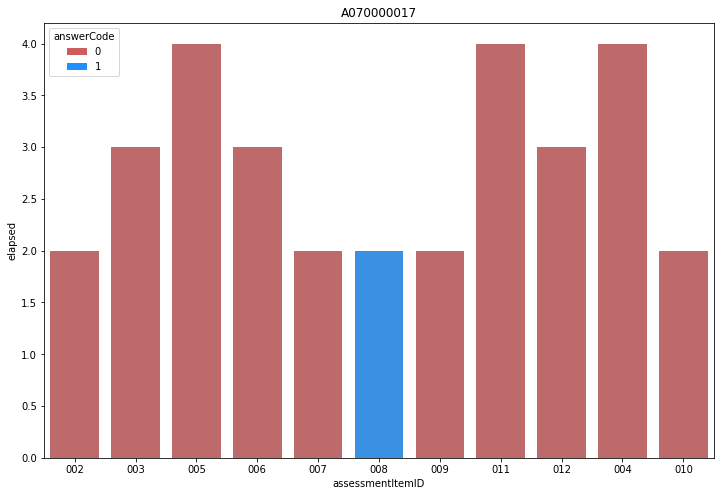

In [59]:
plt.figure(figsize=(12,8))
g = sns.barplot(x=third_passion_student_most_paper_df['assessmentItemID'][1:], y=third_passion_student_most_paper_df['elapsed'], palette=col)
g.set_xticklabels(processed_xtics_list[1:])
g.legend([Patch(facecolor='indianred'), Patch(facecolor='dodgerblue')], [0,1], title='answerCode')
plt.title('A070000017')
plt.show()

뒤에 문제와 앞에문제의 푸는 시간과 맞고 틀리고가 크게 관련성이 보이지 않는다.

## 동일한 태그라면 절대적인 난이도가 존재하는가?

동일한 태그에서 한 유저가 해결한 문제들의 정답여부 분포가 다른 유저들에게도 비슷하게 나타나는가?  

In [132]:
most_tag_df = df[df.KnowledgeTag==7597]
most_tag_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
2234,5,A010050004,A010000050,1,2020-06-07 03:31:59,7597,116063.0
2236,5,A010050006,A010000050,1,2020-06-07 03:32:28,7597,19.0
2237,5,A010050001,A010000050,0,2020-06-07 03:33:51,7597,83.0
2307,5,A010060001,A010000060,1,2020-07-13 10:54:59,7597,808382.0
2310,5,A010060004,A010000060,1,2020-07-13 10:55:01,7597,1.0
...,...,...,...,...,...,...,...
2262832,7221,A010051005,A010000051,1,2020-07-30 13:14:08,7597,70.0
2263463,7255,A010060001,A010000060,1,2020-07-30 08:54:58,7597,13746628.0
2263466,7255,A010060004,A010000060,0,2020-07-30 09:13:56,7597,1014.0
2263467,7255,A010060005,A010000060,0,2020-07-30 09:14:14,7597,18.0


In [133]:
most_tag_df['assessmentItemID'].value_counts()[:3]

A010028004    327
A010028003    327
A010028001    327
Name: assessmentItemID, dtype: int64

In [134]:
most_tag_df['userID'].value_counts()

54      60
1116    60
1766    57
504     56
1079    56
        ..
472      2
3431     2
6154     2
1639     2
4531     2
Name: userID, Length: 851, dtype: int64

In [135]:
most_tag_df['testId'].value_counts()

A010000038    1590
A010000039    1560
A010000049    1256
A010000060    1252
A010000055    1228
A010000028     981
A010000030     963
A010000029     939
A010000050     933
A010000031     918
A010000048     646
A010000051     626
Name: testId, dtype: int64

In [136]:
most_tag_testId_df = most_tag_df.loc[(most_tag_df.assessmentItemID=='A010028003') | (most_tag_df.assessmentItemID=='A010028004') | (most_tag_df.assessmentItemID=='A010028001')]
most_tag_testId_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
8132,14,A010028001,A010000028,0,2020-07-15 10:02:39,7597,46.0
8134,14,A010028003,A010000028,0,2020-07-15 10:03:11,7597,27.0
8135,14,A010028004,A010000028,1,2020-07-15 10:03:55,7597,44.0
9761,16,A010028001,A010000028,0,2020-03-19 08:18:05,7597,94508.0
9763,16,A010028003,A010000028,1,2020-03-19 08:18:43,7597,16.0
...,...,...,...,...,...,...,...
2248746,6713,A010028003,A010000028,1,2020-06-04 11:47:07,7597,28.0
2248747,6713,A010028004,A010000028,1,2020-06-04 11:47:39,7597,32.0
2250981,6775,A010028001,A010000028,1,2020-04-16 02:17:49,7597,1088794.0
2250983,6775,A010028003,A010000028,1,2020-04-16 02:20:09,7597,37.0


In [137]:
most_tag_testId_df[most_tag_testId_df.userID == 3070]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
1709077,3070,A010028001,A010000028,1,2020-03-27 02:50:49,7597,54947.0
1709079,3070,A010028003,A010000028,1,2020-03-27 02:52:04,7597,47.0
1709080,3070,A010028004,A010000028,0,2020-03-27 02:52:21,7597,17.0
1709087,3070,A010028001,A010000028,1,2020-04-02 11:24:24,7597,516743.0
1709089,3070,A010028003,A010000028,1,2020-04-02 11:25:09,7597,13.0
1709090,3070,A010028004,A010000028,1,2020-04-02 11:25:29,7597,20.0
1709155,3070,A010028001,A010000028,1,2020-05-26 05:52:49,7597,409112.0
1709157,3070,A010028003,A010000028,1,2020-05-26 05:55:36,7597,22.0
1709158,3070,A010028004,A010000028,1,2020-05-26 05:56:40,7597,64.0


풀었던 문제를 시간이 지난후에 푸는 경우가 존재  
예전에는 틀렸지만 다시풀어 정답을 맞추게 되는 경우가 존재

In [138]:
most_tag_testId_df['assessmentItemID']

8132       A010028001
8134       A010028003
8135       A010028004
9761       A010028001
9763       A010028003
              ...    
2248746    A010028003
2248747    A010028004
2250981    A010028001
2250983    A010028003
2250984    A010028004
Name: assessmentItemID, Length: 981, dtype: object

In [140]:
most_tag_df['assessmentItemID'].value_counts()[:3]

A010028004    327
A010028003    327
A010028001    327
Name: assessmentItemID, dtype: int64

In [139]:
len(most_tag_testId_df.userID.unique())

321

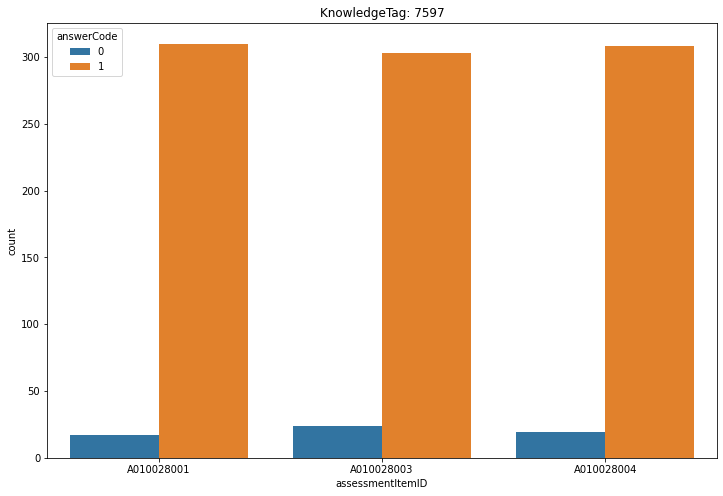

In [141]:
plt.figure(figsize=(12,8))
g = sns.countplot(x=most_tag_testId_df['assessmentItemID'], hue=most_tag_testId_df['answerCode'])
plt.title('KnowledgeTag: 7597')
plt.show()

어쩌면 태그라는 것이 난이도를 의미할 수 있지 않을까?

In [150]:
most_tag_df = df[df.KnowledgeTag==7600]
most_tag_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
2235,5,A010050005,A010000050,1,2020-06-07 03:32:09,7600,10.0
2238,5,A010050003,A010000050,0,2020-06-07 03:34:21,7600,30.0
2308,5,A010060002,A010000060,0,2020-07-13 10:55:00,7600,1.0
2309,5,A010060003,A010000060,1,2020-07-13 10:55:00,7600,0.0
2313,5,A010060007,A010000060,0,2020-07-13 10:55:07,7600,5.0
...,...,...,...,...,...,...,...
2262857,7222,A010044004,A010000044,1,2020-06-06 05:25:44,7600,44.0
2262858,7222,A010044005,A010000044,1,2020-06-06 05:26:13,7600,29.0
2263464,7255,A010060002,A010000060,1,2020-07-30 08:55:39,7600,41.0
2263465,7255,A010060003,A010000060,0,2020-07-30 08:57:02,7600,83.0


In [151]:
most_tag_df['assessmentItemID'].value_counts()[:3]

A010028005    327
A010028002    327
A010048005    323
Name: assessmentItemID, dtype: int64

In [152]:
len(most_tag_testId_df.userID.unique())

0

세가지 문제 모두 푼 유저들이 대다수 이므로 비교가 가능

In [153]:
most_tag_testId_df = most_tag_df.loc[(most_tag_df.assessmentItemID=='A010028005') | (most_tag_df.assessmentItemID=='A010028002') | (most_tag_df.assessmentItemID=='A010048005')]
most_tag_testId_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
4602,8,A010048005,A010000048,0,2020-04-01 05:28:07,7600,42.0
8133,14,A010028002,A010000028,0,2020-07-15 10:02:44,7600,5.0
8136,14,A010028005,A010000028,1,2020-07-15 10:04:59,7600,64.0
9762,16,A010028002,A010000028,1,2020-03-19 08:18:27,7600,22.0
9765,16,A010028005,A010000028,0,2020-03-19 08:19:15,7600,22.0
...,...,...,...,...,...,...,...
2248748,6713,A010028005,A010000028,1,2020-06-04 11:48:17,7600,38.0
2250671,6767,A010048005,A010000048,1,2020-02-11 11:02:09,7600,36.0
2250982,6775,A010028002,A010000028,1,2020-04-16 02:19:32,7600,103.0
2250985,6775,A010028005,A010000028,1,2020-04-16 02:23:23,7600,138.0


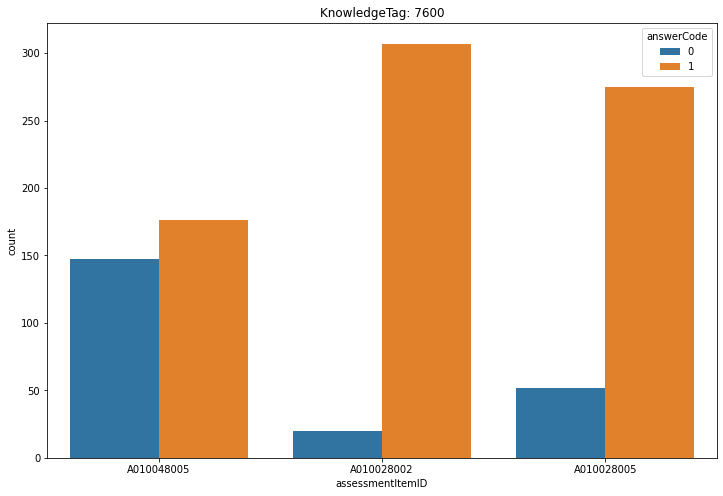

In [154]:
plt.figure(figsize=(12,8))
g = sns.countplot(x=most_tag_testId_df['assessmentItemID'], hue=most_tag_testId_df['answerCode'])
plt.title('KnowledgeTag: 7600')
plt.show()

태그는 난이도라기 보다는 어떠한 챕터(주제) 일 가능성이 높다 절대적인 난이도가 비슷한 것 같지는 않다

## 같은 문제 시간을 두고 중복해서 푼 사람들 존재 (복습)

In [170]:
dfs = df
dfs['tmp'] = 1
dfss = dfs[['userID', 'assessmentItemID','tmp']].groupby(['userID', 'assessmentItemID']).count()

In [172]:
dfss['tmp'].value_counts()

1    2175514
2      44285
3        834
Name: tmp, dtype: int64

In [173]:
dfss[dfss.tmp ==3]

tmp
userID assessmentItemID     
165    A090001001          3
       A090001002          3
       A090001003          3
       A090001004          3
       A090001005          3
...                      ...
3775   A020118001          3
       A020118002          3
       A020118003          3
       A020118004          3
       A020118005          3

[834 rows x 1 columns]

In [174]:
df.loc[(df.userID == 165) & (df.assessmentItemID == 'A090001001')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,tmp
127529,165,A090001001,A090000001,1,2020-02-20 02:43:48,4697,0.0,1
127661,165,A090001001,A090000001,1,2020-03-12 06:39:07,4697,294013.0,1
128577,165,A090001001,A090000001,0,2020-12-24 01:09:27,4697,67523.0,1


In [30]:
df.loc[(df.userID == 165) & (df.assessmentItemID == 'A090001002')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
127530,165,A090001002,A090000001,1,2020-02-20 02:43:50,4697,2.0
127662,165,A090001002,A090000001,0,2020-03-12 06:39:43,4697,36.0
128578,165,A090001002,A090000001,0,2020-12-24 01:15:25,4697,358.0


In [31]:
df.loc[(df.userID == 165) & (df.assessmentItemID == 'A090001003')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
127531,165,A090001003,A090000001,1,2020-02-20 02:43:53,10174,3.0
127663,165,A090001003,A090000001,0,2020-03-12 06:39:48,10174,5.0
128579,165,A090001003,A090000001,1,2020-12-24 01:15:27,10174,2.0


In [32]:
df.loc[(df.userID == 165) & (df.assessmentItemID == 'A090001004')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
127532,165,A090001004,A090000001,1,2020-02-20 02:43:57,78,4.0
127664,165,A090001004,A090000001,0,2020-03-12 06:39:53,78,5.0
128580,165,A090001004,A090000001,0,2020-12-24 01:15:29,78,2.0


In [33]:
df.loc[(df.userID == 165) & (df.assessmentItemID == 'A090001005')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
127533,165,A090001005,A090000001,1,2020-02-20 02:44:01,78,4.0
127665,165,A090001005,A090000001,1,2020-03-12 06:40:08,78,15.0
128581,165,A090001005,A090000001,0,2020-12-24 01:15:31,78,2.0


In [175]:
df.loc[(df.userID == 3070) & (df.assessmentItemID == 'A010028001')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,tmp
1709077,3070,A010028001,A010000028,1,2020-03-27 02:50:49,7597,54947.0,1
1709087,3070,A010028001,A010000028,1,2020-04-02 11:24:24,7597,516743.0,1
1709155,3070,A010028001,A010000028,1,2020-05-26 05:52:49,7597,409112.0,1


In [177]:
df.loc[(df.userID == 3070) & (df.assessmentItemID == 'A010028004')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed,tmp
1709080,3070,A010028004,A010000028,0,2020-03-27 02:52:21,7597,17.0,1
1709090,3070,A010028004,A010000028,1,2020-04-02 11:25:29,7597,20.0,1
1709158,3070,A010028004,A010000028,1,2020-05-26 05:56:40,7597,64.0,1


In [29]:
df.loc[(df.userID == 3775) & (df.assessmentItemID == 'A020118001')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
1911521,3775,A020118001,A020000118,1,2020-09-18 07:47:41,8014,2058.0
1911574,3775,A020118001,A020000118,1,2020-09-26 04:15:24,8014,9652.0
1911697,3775,A020118001,A020000118,1,2020-10-23 09:03:19,8014,6475.0


시험을 풀고 정답이 공개되는지 체크 -> 푼 간격이 짧은데 틀리는 문제가 있는지 확인  
유저의 성실도 측정 -> 만약 문제를 대충푼다면 모든 문제를 대충 풀 수 있을 것이다. -> 평균 시험지 풀이 시간보다 해당 시험지의 풀이 시험지 풀이 시간이 현저하게 낮음

## 유저 성실도

In [60]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0
...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,24.0
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,6632178.0
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,11.0
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,46.0


In [107]:
processed_df = df[df.elapsed < 650]
processed_df = processed_df[['testId', 'answerCode', 'elapsed']].groupby('testId').mean().sort_values(['answerCode', 'elapsed'])
processed_df

,answerCode,elapsed
testId,,
A090000035,0.299605,40.535968
A090000071,0.311475,37.590164
A080000129,0.312956,59.132361
A070000075,0.318733,33.267474
A080000049,0.325206,32.327566
...,...,...
A060000002,0.941481,28.395556
A010000161,0.941558,33.861472
A060000001,0.943428,20.914309


In [102]:
target_test_df = df[df.testId == 'A040000187']
target_test_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
3243,6,A040187001,A040000187,1,2020-08-30 09:56:19,2129,5527.0
3244,6,A040187002,A040000187,1,2020-08-30 09:56:29,2129,10.0
3245,6,A040187003,A040000187,1,2020-08-30 09:56:47,2129,18.0
3246,6,A040187004,A040000187,1,2020-08-30 09:56:52,2129,5.0
3247,6,A040187005,A040000187,1,2020-08-30 09:57:01,2129,9.0
...,...,...,...,...,...,...,...
2266377,7427,A040187001,A040000187,1,2020-10-15 02:51:40,2129,701983.0
2266378,7427,A040187002,A040000187,1,2020-10-15 02:52:16,2129,36.0
2266379,7427,A040187003,A040000187,1,2020-10-15 02:52:44,2129,28.0
2266380,7427,A040187004,A040000187,1,2020-10-15 02:52:55,2129,11.0


In [103]:
len(target_test_df.assessmentItemID.unique())

5

In [104]:
trust_target_test_df = target_test_df[(target_test_df.elapsed < 650)]
trust_target_test_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
3244,6,A040187002,A040000187,1,2020-08-30 09:56:29,2129,10.0
3245,6,A040187003,A040000187,1,2020-08-30 09:56:47,2129,18.0
3246,6,A040187004,A040000187,1,2020-08-30 09:56:52,2129,5.0
3247,6,A040187005,A040000187,1,2020-08-30 09:57:01,2129,9.0
5795,9,A040187001,A040000187,1,2020-10-14 12:55:30,2129,66.0
...,...,...,...,...,...,...,...
2263926,7278,A040187005,A040000187,1,2020-09-04 10:55:20,2129,5.0
2266378,7427,A040187002,A040000187,1,2020-10-15 02:52:16,2129,36.0
2266379,7427,A040187003,A040000187,1,2020-10-15 02:52:44,2129,28.0
2266380,7427,A040187004,A040000187,1,2020-10-15 02:52:55,2129,11.0


In [105]:
trust_target_test_df.groupby('userID').sum().sort_values('elapsed', ascending=False)

,answerCode,KnowledgeTag,elapsed
userID,,,
5929,5,10645,987.0
4777,4,8516,742.0
2037,5,10645,681.0
1834,4,8516,624.0
18,4,8516,498.0
...,...,...,...
5211,3,6387,19.0
109,1,8516,16.0
635,0,8516,15.0


In [99]:
trust_target_test_df[trust_target_test_df['userID'] == 635]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,elapsed
456244,635,A040187002,A040000187,0,2020-07-10 07:39:34,2129,1.0
456245,635,A040187003,A040000187,0,2020-07-10 07:39:37,2129,3.0
456246,635,A040187004,A040000187,0,2020-07-10 07:39:40,2129,3.0
456247,635,A040187005,A040000187,0,2020-07-10 07:39:48,2129,8.0


In [95]:
trust_target_test_df.groupby('userID').sum().sort_values('answerCode', ascending=False)

,answerCode,KnowledgeTag,elapsed
userID,,,
3677,8,17032,161.0
174,8,17032,103.0
1264,5,10645,219.0
3072,5,10645,291.0
4685,5,10645,77.0
...,...,...,...
5158,2,8516,31.0
109,1,8516,16.0
6534,0,8516,13.0


In [115]:
trust_target_test_df[['answerCode', 'userID']].groupby('userID').sum().value_counts()

answerCode
4             208
3              31
5              23
2               4
0               3
8               2
1               1
dtype: int64